In [1]:
import os
import pynwb
import h5py
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import pywt
import matplotlib
import graph
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec

from scipy import signal
from scipy.fftpack import next_fast_len
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import filtfilt, hilbert, remez, sosfiltfilt, butter, coherence

import load_data
import LFP
import graph

from fooof import FOOOFGroup
from fooof import Bands
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg, get_band_peak_fm
from fooof.plts.spectra import plot_spectra
from fooof.sim.gen import gen_aperiodic
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits

C:\Users\ML_4\AppData\Local\Temp\ipykernel_23316\1776902342.py:28: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [ ]:
# get flattened power spectrum using fooof

for date in ['031723','032823','033123', '032023', '040423', '040723']:

    
    nwbfile = load_data.load_nwbfile('Bart',date) 
    
    query = 'trialerror<2'
    reward_df = nwbfile.intervals['reward_on'].to_dataframe().query(query)
    reward_aligned = epoch_aligned_band(date,reward_df,[0,2000])
    
    # get psd
    n_trials = reward_aligned['LFP'].shape[0]
    nchannels = reward_aligned['LFP'].shape[1]
    psd = np.zeros((nchannels,n_trials,101))
    flat_spec = np.zeros((nchannels,49))
    fg = FOOOFGroup()
    
    for ch in tqdm(range(nchannels)):
        
        for trial in range(n_trials):
            psd_freqs, psd[ch,trial,:] = signal.welch(reward_aligned['LFP'][trial,ch,::5], fs=200, nperseg=200, noverlap=180)
        
        fm.fit(psd_freqs, psd[ch,:,:].mean(axis=0), [2, 50])
        init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
        
        # Recompute the flattened spectrum using the initial aperiodic fit
        flat_spec[ch,:] = fm.power_spectrum-init_ap_fit
    
    np.save(f'D:/Alpha/Session {date} fooof flat psd', flat_spec)

In [2]:
all_spec = pd.DataFrame()

for date in ['031723','032823','033123', '032023', '040423', '040723']:
    
    flat_spec = np.load(f'D:/Alpha/Session {date} fooof flat psd.npy')
    nwbfile = load_data.load_nwbfile('Bart',date) 
    unitNames = nwbfile.units.to_dataframe()
    probes = unitNames.drop_duplicates('probe')
    subfield_spec = []   # collect rows here
    
    for p in probes.probe.unique():
        # subset for this probe
        sub_df = probes.query("probe == @p")
    
        # channel numbers belonging to this probe
        probe_channels = np.arange(sub_df.start_channel.min() - 1,
                                   sub_df.end_channel.max())
    
        # subfield labels for each channel
        # IMPORTANT: must align channels with sub_df rows
        channel_subfield = []
        for _, row in sub_df.iterrows():
            chs = np.arange(row.start_channel - 1, row.end_channel)
            channel_subfield.extend([row.subfield] * len(chs))
    
        channel_subfield = np.array(channel_subfield)
    
        # extract the spectrum for these channels
        spec_subset = flat_spec[probe_channels, :]      # shape: (#channels, #freqs)
        n_channels, n_freqs = spec_subset.shape
    
        # real frequency values (f_2, f_3, f_4, ...)
        frequency_vals = np.arange(2, 2 + n_freqs)
    
        # build a long-format dataframe for this probe
        df = pd.DataFrame({
            "session": date,
            "probe": np.repeat(p, n_channels * n_freqs),
            "channel": np.repeat(probe_channels, n_freqs),
            "subfield": np.repeat(channel_subfield, n_freqs),
            "frequency": np.tile(frequency_vals, n_channels),
            "power": spec_subset.flatten()
        })
    
        subfield_spec.append(df)
    
    # concatenate across all probes
    subfield_spec = pd.concat(subfield_spec, ignore_index=True)
    all_spec = pd.concat([all_spec,subfield_spec])

In [3]:
all_spec.to_pickle("D:/Alpha/fooof_flatten_psd.pkl")

Text(0.5, 1.0, 'Periodic component (FOOOF)')

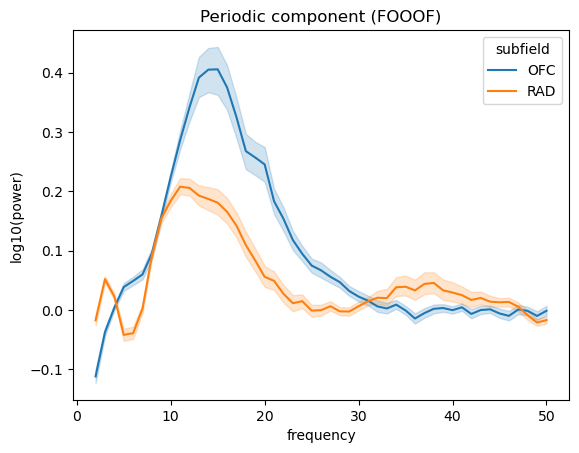

In [9]:
plt.close('all')
date='040723'
sns.lineplot(data=all_spec.query('session==@date'),x='frequency',y='power',hue='subfield')
plt.ylabel('log10(power)')
plt.title('Periodic component (FOOOF)')
# plt.savefig('D:/Alpha/fooof_flatten_psd')

In [ ]:
date = '031723'
session_spec = all_spec.query('session==@date')

region='OFC'
region_spec = session_spec.query('subfield==@region')
ofc_channel = region_spec.loc[region_spec['power'].idxmax()]['channel']

region='CA3'
region_spec = session_spec.query('subfield==@region')
hpc_channel = region_spec.loc[region_spec['power'].idxmax()]['channel']